## Hash Algorithm and Image Generator

In [171]:
import hashlib
import os
import pathlib
from bitstring import BitArray
from pathlib import Path
from typing import Union, Any
from PIL import Image
from random import choice, shuffle, randint

In [172]:
from config import COLLECTION_DIR

imgs_path = COLLECTION_DIR
cat_collection_path = imgs_path / "cat"
robot_collection_path = imgs_path / "robot"

print(cat_collection_path)
print(robot_collection_path)

/windows10/Users/hamng/Desktop/projects/delicacy/images/cat
/windows10/Users/hamng/Desktop/projects/delicacy/images/robot


In [173]:
from attrs import define, field
from typing import Optional, Sequence
from collections.abc import Iterable, Iterator


@define(frozen=True, eq=False, order=False)
class Collection:
    name: str
    path: Path
    layer_names: Iterable[str] = field(converter=tuple)

    @layer_names.default  # type: ignore
    def _layer(self) -> Iterator[str]:
        return (d.stem for d in self.layer_paths)

    @property
    def layer_paths(self) -> Iterator[Path]:
        return (d for d in self.path.iterdir() if d.is_dir())

    @property
    def layers(self):
        return zip(self.layer_names, self.layer_paths)

In [174]:
cat_collection = Collection("Cat", cat_collection_path)
robot_collection = Collection("Robot", robot_collection_path)

print(cat_collection, "\n\n", robot_collection)

Collection(name='Cat', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/cat'), layer_names=('000#00body', '001#01fur', '002#02eyes', '003#03mouth', '004#04accessories')) 

 Collection(name='Robot', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot'), layer_names=('000#Body', '001#Face', '002#Mouth', '003#Eyes', '004#Accessory'))


In [175]:
from collections.abc import Iterator


class ImageGenerator:
    def __init__(
        self, collection: Collection, hash_fun=hashlib.sha512
    ) -> None:
        self.collection = collection
        self.hash_func = hash_fun

    def _hash(self, key: Union[bytes, str], data: Any = "") -> BitArray:

        _key = key.encode("utf8") if not isinstance(key, bytes) else key
        _data = str(data).encode("utf8")

        hashed = self.hash_func(_key)
        hashed.update(_data)

        return BitArray(bytes=hashed.digest())

    @staticmethod
    def _pick(_hash: BitArray, path: Path) -> Path:
        imgs = sorted(path.iterdir())
        chosen_idx = _hash.uint % len(imgs)
        return imgs[chosen_idx]

    def _pick_layers(self, seed: Union[bytes, BitArray]) -> Iterator[Path]:
        if isinstance(seed, bytes):
            seed = BitArray(bytes=seed)

        base_hash = self._hash(seed.bytes, self.collection.name)

        for name, path in self.collection.layers:
            layer_hash = self._hash(base_hash.bytes, name)
            yield self._pick(layer_hash, path)

    def _assemble(self, layers, size=(300, 300), proportion=0.7):
        """Build the image!"""

        # Paste in each piece.
        frame_size = fx, fy = (1024, 1024)
        layer_size = lx, ly = int(fx * proportion), int(fy * proportion)
        box = (fx - lx) // 2, fy - ly

        frame = Image.new(mode="RGBA", size=frame_size)

        for item in layers:
            img = Image.open(item).resize(layer_size)
            frame.paste(img, box, mask=img)
            img.close()

        return frame.resize(size)

    def generate(self, phrase: str, data: Any = "", *args, **kwds) -> Image:
        seed = self._hash(phrase, data)
        layers = self._pick_layers(seed)
        return self._assemble(layers, *args, **kwds)

In [176]:
img_gen = ImageGenerator(robot_collection)

In [177]:
img_gen._hash("test")

BitArray('0xee26b0dd4af7e749aa1a8ee3c10ae9923f618980772e473f8819a5d4940e0db27ac185f8a0e1d5f84f88bc887fd67b143732c304cc5fa9ad8e6f57f50028a8ff')

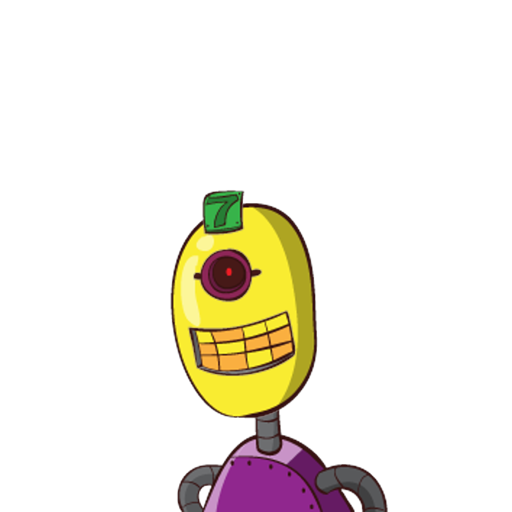

In [178]:
my_img = img_gen.generate("hamnghi", size=(512, 512), proportion=0.85)
my_img

## Generative Art for Background

In [179]:
from lxml import etree

In [180]:
root = etree.Element("root")

root.append(etree.Element("child1"))
child2 = etree.SubElement(root, "child2")
child3 = etree.SubElement(root, "child3")

root.tag

'root'

In [181]:
child = root[0]
child.tag

'child1'

In [182]:
root.insert(0, etree.Element("child0"))

In [183]:
from lxml import etree
from lxml.etree import Element


def eprint(element: etree._Element) -> None:
    print(etree.tostring(element, pretty_print=True).decode("utf8"))


def get_canvas(width: int, height: int, **kwds: str) -> Element:
    tag = dict(
        width=str(width),
        height=str(height),
        xmlns="http://www.w3.org/2000/svg",
    )
    tag |= kwds
    nsmap = dict(xlink="http://www.w3.org/1999/xlink")
    return Element("svg", nsmap=nsmap, attrib=tag)

In [184]:
canvas = get_canvas(512, 512, background_color="black")
eprint(canvas)
canvas.attrib

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg" background_color="black"/>



{'width': '512', 'height': '512', 'xmlns': 'http://www.w3.org/2000/svg', 'background_color': 'black'}

In [185]:
from typing import ClassVar, Optional

from attrs import asdict, field, frozen
from attrs.validators import and_, ge, in_, le
from cytoolz.dicttoolz import valfilter


class Style:
    _main_property: ClassVar[str] = ""

    def __str__(self) -> str:
        name = self.__class__.__name__.lower()
        prop = self._main_property
        keyfunc = lambda k: name if k == prop else f"{name}-{k}"  # noqa

        return " ".join(
            f"{keyfunc(key)}: {val};"
            for key, val in asdict(self).items()
            if val is not None
        )


@frozen
class Stroke(Style):
    _main_property: ClassVar[str] = "color"

    color: str = "black"
    opacity: float = field(default=1, validator=and_(ge(0), le(1)))

    width: float = 1
    linecap: Optional[str] = field(
        default=None,
        validator=in_(("butt", "square", "round", None)),
    )
    linejoin: Optional[str] = field(
        default=None,
        validator=in_(("miter", "round", "bevel", None)),
    )
    miterlimit: Optional[float] = field(default=None, init=False)

    def set_miterlimit(self, value):
        if self.linejoin != "miter":
            raise ValueError(
                "miterlimit can only be set if linejoin is 'miter'"
            )
        self.miterlimit = str(value)


@frozen
class Fill(Style):
    _main_property: ClassVar[str] = "color"

    color: str = "black"
    opacity: float = field(default=1, validator=and_(ge(0), le(1)))
    rule: Optional[str] = field(
        default=None, validator=in_(("nonzero", "evenodd", None))
    )

In [186]:
stroke, fill = Stroke(), Fill()
str(stroke), str(fill)

('stroke: black; stroke-opacity: 1; stroke-width: 1;',
 'fill: black; fill-opacity: 1;')

In [187]:
from typing import Any

from attrs import define, field
from lxml import etree
from lxml.etree import _Element


@define
class SVGElement:
    _element: _Element = field(init=False, repr=False)

    def __repr__(self) -> str:
        return repr(self._element)

    def __str__(self) -> str:
        return bytes(self).decode("utf8")

    def __bytes__(self) -> bytes:
        return etree.tostring(self._element, pretty_print=True)

    def __call__(self) -> _Element:
        return self._element

    def set(self, tag: str, value: Any) -> None:
        self._element.set(tag, value)

    @classmethod
    def from_etree_element(cls, value: _Element) -> "SVGElement":
        instance = cls()
        instance._element = value
        return instance

In [292]:
import random
from random import Random
from math import cos, radians, sin
from typing import NamedTuple


class Point(NamedTuple):
    x: float
    y: float

    @classmethod
    def from_polar_radians(cls, radius, theta):
        x = radius * cos(theta)
        y = radius * sin(theta)
        return cls(x, y)

    @classmethod
    def from_polar_degree(cls, radius, theta):
        theta = radians(theta)
        return cls.from_polar_radian(radius, theta)

    @classmethod
    def randpoint(
        cls,
        xlim: tuple[int, int] = (0, 512),
        ylim: tuple[int, int] = (0, 512),
        fixed_x: bool = False,
        fixed_y: bool = False,
    ) -> "Point":

        x = random.choice(xlim) if fixed_x else random.randint(*xlim)
        y = random.choice(ylim) if fixed_y else random.randint(*ylim)

        return cls(x, y)


In [302]:
Point.randpoint(xlim, ylim)

Point(x=501, y=111)

In [332]:
[True, False, False].index(True)

0

In [298]:
def rand_points(
    num: int,
    xlim: tuple[int, int],
    ylim: tuple[int, int],
    seed: Optional[int] = None,
):
    if seed is not None:
        random.seed(seed)
    return (Point.randpoint(xlim, ylim) for _ in range(num))

In [334]:
def rand_bounded_points(
    num: int,
    xlim: tuple[int, int],
    ylim: tuple[int, int],
    seed: Optional[int] = None,
):
    """
    generate random points whose x and y are randomly bounded to the limit
    """

    if seed is not None:
        random.seed(seed)

    fxs = random.choices([True, False], k=num)  # fixed flags for x
    fys = random.choices([True, False], k=num)  # fixed flags for y

    for _, fx, fy in zip(range(num), fxs, fys):
        yield Point.randpoint(xlim, ylim, fx, fy)


In [285]:
def rand_fixed_point(
    num: int,
    xlim: tuple[int, int],
    ylim: tuple[int, int],
):
    nx = ny = num // 2
    if num % 2 != 0:
        nx += 1

    xbounded = [Point.randpoint(xlim, ylim, fixed_x=True) for _ in range(nx)]
    ybounded = [Point.randpoint(xlim, ylim, fixed_y=True) for _ in range(ny)]
    points = xbounded + ybounded

    # shuffle requires a materialized iterable, so cannot use iterator here
    random.shuffle(points)

    # use yield from to ensure a consistent api
    # amongst the rand_*_points functions
    yield from points

In [190]:
from decorator import decorator
from typing import Callable, Optional, Any
from types import MethodType
from functools import partial
from operator import methodcaller
from cytoolz import curry


@decorator
def chainable(method: MethodType, updater_name: str = "_update", *args, **kwds):
    self = args[0]
    value = method(*args, **kwds)
    methodcaller(updater_name, value)(self)
    return self



class Transform:
    
    def __init__(self):
        self._storage = ""

    def _update(self, value: Any) -> None:
        self._storage += value

    @chainable
    def translate(self, x: float, y: Optional[None] = None) -> str:
        y = 0 if y is None else y
        return f" translate({x},{y})"

    @chainable
    def rotate(
        self, angle: float, x: Optional[None] = None, y: Optional[None] = None
    ) -> str:
        if x is None and y is None:
            return f" rotate({angle})"
        else:
            return f" rotate({angle},{x},{y})"

    @chainable
    def scale(self, x: float, y: Optional[None] = None) -> str:
        y = x if y is None else y
        return f" scale({x},{y})"

    @chainable
    def skewX(self, x: int) -> str:
        return f" skewX({x})"

    @chainable
    def skewY(self, y: int) -> str:
        return f" skewY({y})"

    @chainable
    def matrix(
        self, a: float, b: float, c: float, d: float, e: float, f: float
    ) -> str:
        return f" matrix({a},{b},{c},{d},{e},{f})"

    def __call__(self) -> str:
        return self._storage.lstrip()

In [191]:
tr = Transform().translate(5).skewX(4)
tr()

'translate(5,0) skewX(4)'

In [192]:
import re
from typing import Optional
from cytoolz import dicttoolz as dz
from functools import cache


class ExtendedElement(SVGElement):
    
    @staticmethod
    @cache
    def extract_styles(style_str: str, kind: Optional[str] = None) -> dict[str, str]:
        print("cache hits")
        temp = [item.strip() for item in re.split(r"[:;]", style_str)]
        keys, values = temp[0:-1:2], temp[1:-1:2]

        if kind is not None:
            style_set = set(k.split("-")[0] for k in keys)
            if (kind:=kind.lower()) not in style_set:
                raise ValueError("Not a valid style")
        
        style_dict = dict(zip(keys, values))

        if kind is None:
            return style_dict
        
        return dz.keyfilter(lambda x: kind in x, style_dict)

    @property
    def styles(self):
        return self.extract_styles(self._element.get('style'))
    

    def add_style(self, style: Style) -> None:
        super().set("style", str(style))

    def apply_styles(self, *styles: Style) -> None:
        _styles = " ".join(str(style) for style in styles)
        super().set("style", _styles)

    def set_style(self, style: Style) -> None:
        _styles = self().get("style")
        if _styles is None:
            self.add_style(style)
        else:
            kind = style.__class__.__name__.lower()
            remains = ";".join(s for s in _styles.split(";") if kind not in s)
            _styles = str(style) + remains
            super().set("style", _styles)

    def add_transform(self, transform: Transform) -> None:
        value = transform()
       ] | None if value == "":
            raise ValueError("empty transform")
        super().set("transform", value)

In [193]:
style_str = 'stroke: black;stroke-opacity: 1;\nfill-opacity: 1;stroke-width: 1;fill: black;'
ExtendedElement.extract_styles(style_str, "stroke")

cache hits


{'stroke': 'black', 'stroke-opacity': '1', 'stroke-width': '1'}

In [194]:
from itertools import chain

@define
class Line(ExtendedElement):
    start: Point
    stop: Point

    def __attrs_post_init__(self) -> None:
        tags = ("x1", "y1", "x2", "y2")
        values = (str(v) for v in chain(self.start, self.stop))
        self._element = Element("line", attrib=dict(zip(tags, values)))

In [196]:
line = Line(Point(0, 100), Point(200, 500))

stroke = Stroke(color="white", width=5)
fill = Fill(color="black", opacity=0.8)
transform = Transform().translate(4, 12).rotate(45).scale(3, 15)

line.apply_styles(stroke, fill)
line.add_transform(transform)

eprint(line())
line.styles

<line x1="0" y1="100" x2="200" y2="500" style="stroke: white; stroke-opacity: 1; stroke-width: 5; fill: black; fill-opacity: 0.8;" transform="translate(4,12) rotate(45) scale(3,15)"/>

cache hits


{'stroke': 'white',
 'stroke-opacity': '1',
 'stroke-width': '5',
 'fill': 'black',
 'fill-opacity': '0.8'}

In [199]:
from colorsys import hsv_to_rgb
import random


class RGBColor(NamedTuple):
    red: int
    green: int
    blue: int

    @staticmethod
    def _clamp(x):
        """
        _clamp ensures that 0 <= {r,g,b} <= 255
        https://stackoverflow.com/a/3380754
        """
        return max(0, min(x, 255))

    def to_hex(self):
        """
        convert rgb to hex representation
        https://stackoverflow.com/a/3380754
        """
        r, g, b = tuple(self._clamp(c) for c in self)
        return f"#{r:02x}{g:02x}{b:02x}"

    @classmethod
    def from_iterable(cls, it):
        return cls(*it)

    @classmethod
    def from_fex(cls, hexstring: str):
        _len = len(hexstring)

        if _len != 7:
            raise ValueError("Invalid hex color")

        hexstring = hexstring.lstrip("#")

        return cls.from_iterable(
            int(hexstring[i : i + 2], 16) for i in range(0, _len - 1, 2)
        )

    @classmethod
    def randcolor(cls, style="normal"):
        available_styles = ("pastel", "neon", "normal")

        if style not in available_styles:
            raise ValueError(f"style must be one of: {available_styles}")

        if style == "neon":
            h, s, v = random.random(), 1, 1
        elif style == "pastel":
            h, s, v = random.random(), random.random(), 1
        else:
            h, s, v = tuple(random.random() for _ in range(3))

        return cls.from_iterable(int(c * 255) for c in hsv_to_rgb(h, s, v))


def lerp(start: RGBColor, end: RGBColor, mix: float = 0) -> RGBColor:
    if mix < 0 or mix > 1:
        raise ValueError("mix must be in range: [0, 1]")
    rgb_it = (int(abs(s - e) * mix) + min(s, e) for s, e in zip(start, end))
    return RGBColor.from_iterable(rgb_it)


def lerp_gradient(start: RGBColor, end: RGBColor, k: int = 10):
    return (lerp(start, end, i / k) for i in range(k))

In [200]:
from cairosvg import svg2png
from io import BytesIO


def svg2img(bytestring, background_color="black") -> Image:
    img_bytes = svg2png(
        bytestring=bytestring, background_color=background_color
    )
    byte_io = BytesIO(img_bytes)
    return Image.open(byte_io)


def canvas2img(canvas: etree.Element, *args, **kwds) -> etree.Element:
    canvas_bytestring = etree.tostring(canvas)
    return svg2img(canvas_bytestring, *args, **kwds)

In [201]:
class Size(NamedTuple):
    width: int
    height: int

In [202]:
from itertools import tee
from typing import Optional, Union


def create_line(
    start: Point,
    stop: Point,
    color: RGBColor,
    width: int,
    *args: str,
    **kwds: str
) -> Line:
    stroke = Stroke(color.to_hex(), width=width, *args, **kwds)
    line = Line(start, stop)
    line.set_style(stroke)
    return line


def pixelgami(
    size: Optional[Size] = None,
    num: int = 20,
    scale: float = 0.2,
    offset: int = 0,
    color_style="pastel",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    points = rand_fixed_point(
        num,
        (0 + offset, size.width - offset),
        (0 + offset, size.height - offset),
    )
    palette = lerp_gradient(
        RGBColor.randcolor(color_style),
        RGBColor.randcolor(color_style),
        num,
    )

    start_points, end_points = tee(points)
    origin = next(end_points)

    for i, (start, end, color) in enumerate(
        zip(start_points, end_points, palette), 1
    ):
        width = i * scale
        line = create_line(start, end, color, width)
        canvas.append(line())
    else:
        color = next(palette)
        width = (i + 1) * scale
        end_line = create_line(end, origin, color, width)
        canvas.append(end_line())

    return canvas

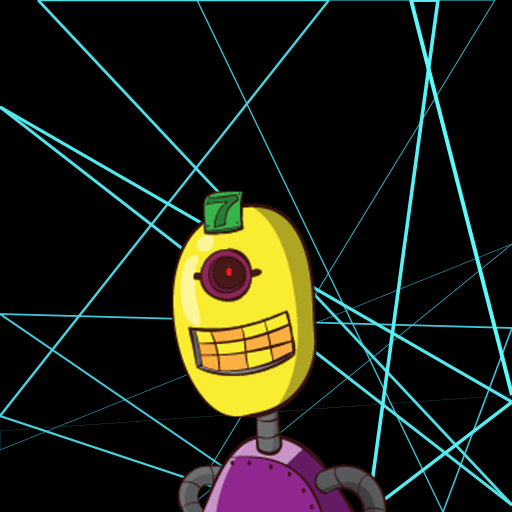

In [203]:
pxgm = pixelgami()
bg_img = canvas2img(pxgm)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [204]:
import numpy as np
from itertools import count, takewhile


def linspace(start, stop, n_samples):
    if n_samples < 0:
        raise ValueError("Number of samples, must be non-negative")

    step = (stop - start) / (n_samples - 1)
    bound = step * (n_samples - 1) + 1e-12

    space = takewhile(lambda x: x <= bound, count(start, step))

    return space


np.linspace(0, 100, 15), list(linspace(0, 100, 15))

(array([  0.        ,   7.14285714,  14.28571429,  21.42857143,
         28.57142857,  35.71428571,  42.85714286,  50.        ,
         57.14285714,  64.28571429,  71.42857143,  78.57142857,
         85.71428571,  92.85714286, 100.        ]),
 [0,
  7.142857142857143,
  14.285714285714286,
  21.42857142857143,
  28.571428571428573,
  35.714285714285715,
  42.85714285714286,
  50.00000000000001,
  57.14285714285715,
  64.28571428571429,
  71.42857142857143,
  78.57142857142857,
  85.71428571428571,
  92.85714285714285,
  99.99999999999999])

In [205]:
from functools import partial
from typing import Union


def wraps(
    tag,
    *childs: Union[etree._Element, SVGElement],
    extended: bool = True,
    **kwds
) -> SVGElement:
    root = etree.Element(tag, **kwds)
    try:
        root.extend(childs)
    except TypeError:
        root.extend(child() for child in childs)

    element_cls = ExtendedElement if extended else SVGElement
    return element_cls.from_etree_element(root)


defs = partial(wraps, "defs")

In [206]:
from attrs.validators import in_
from lxml.etree import SubElement


@define(init=False, order=False, eq=False)
class BaseGradient(SVGElement):
    id: str
    spreadMethod: str = field(
        default="pad", validator=in_(("pad", "repeat", "reflect"))
    )

    def add_stop(self, offset: float, color: str, opacity: float) -> None:
        if not 0 <= offset <= 1:
            raise ValueError(f"offset: {offset} not in range: [0, 1]")

        attributes = {
            "offset": f"{offset:.0%}",
            "stop-color": color,
            "stop-opacity": str(float(opacity)),
        }

        se = SubElement(self(), "stop", **attributes)

    @classmethod
    def create_gradient(cls, colors, *args, **kwds):
        n_colors = len(colors)
        gradient = cls(*args, **kwds)

        for color, offset in zip(colors, linspace(0, 1, n_colors)):
            gradient.add_stop(offset, color, 1)

        return gradient

In [207]:
@define(order=False, eq=False)
class LinearGradient(BaseGradient):
    id: str = "linearGradient"
    start: tuple[float, float] = field(default=(0, 0))
    stop: tuple[float, float] = field(default=(1, 1))

    def __attrs_post_init__(self) -> None:
        tags = ["x1", "y1", "x2", "y2"]
        start = (f"{i:.0%}" for i in self.start)
        stop = (f"{i:.0%}" for i in self.stop)

        lg = Element("linearGradient")
        lg.set("id", str(self.id))

        for attr, val in zip(tags, chain(start, stop)):
            lg.set(attr, val)

        lg.set("spreadMethod", self.spreadMethod)
        self._element = lg

In [208]:
@define(order=False, eq=False)
class RadialGradient(BaseGradient):
    radius: float = 0.55
    id: str = "radialGradient"
    center: tuple[float, float] = field(default=(0.5, 0.5))
    focus: tuple[float, float] = field(default=(0.5, 0.5))

    def __attrs_post_init__(self) -> None:
        tags = ["cx", "cy", "fx", "fy"]
        center = (f"{i:.0%}" for i in self.center)
        focus = (f"{i:.0%}" for i in self.focus)

        rg = Element("radialGradient")
        rg.set("id", str(self.id))
        rg.set("r", f"{self.radius:.0%}")

        for attr, val in zip(tags, chain(center, focus)):
            rg.set(attr, val)

        rg.set("spreadMethod", self.spreadMethod)
        self._element = rg

In [209]:
rg = RadialGradient.create_gradient(
    colors=["#e63946", "#e0aaff", "#240046", "#1d3557"]
)

print(defs(rg))

<defs>
  <radialGradient id="radialGradient" r="55%" cx="50%" cy="50%" fx="50%" fy="50%" spreadMethod="pad">
    <stop offset="0%" stop-color="#e63946" stop-opacity="1.0"/>
    <stop offset="33%" stop-color="#e0aaff" stop-opacity="1.0"/>
    <stop offset="67%" stop-color="#240046" stop-opacity="1.0"/>
    <stop offset="100%" stop-color="#1d3557" stop-opacity="1.0"/>
  </radialGradient>
</defs>



In [210]:
from itertools import chain
from collections.abc import Iterable


@define
class Polygon(ExtendedElement):
    points: Iterable[Point]

    def __attrs_post_init__(self) -> None:

        points = " ".join("{},{}".format(*p) for p in self.points)
        polygon = Element("polygon", points=points)
        self._element = polygon

In [211]:
def get_reference(element):
    return f"url(#{element.id})"


get_reference(rg)

'url(#radialGradient)'

In [212]:
def karafuru(
    size: Optional[Size] = None,
    n_points: int = 50,
    colors=None,
    n_colors: int = 2,
    gradient_type: str = "linear",
    color_style: str = "neon",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    if colors is None:
        colors = tuple(
            RGBColor.randcolor(color_style).to_hex() for _ in range(n_colors)
        )

    if gradient_type not in ["linear", "radial"]:
        raise ValueError('gradient_type can only be ["linear", "radial"]')

    gradient = LinearGradient if gradient_type == "linear" else RadialGradient
    gradient = gradient.create_gradient(colors, spreadMethod="reflect")
    defs_gradient = defs(gradient)

    points = rand_bounded_points(n_points, (0, size.width), (0, size.height))
    stroke = Stroke(color=get_reference(gradient), width=1)

    polygon = Polygon(points)
    polygon.set_style(stroke)

    canvas.append(defs_gradient())
    canvas.append(polygon())

    return canvas

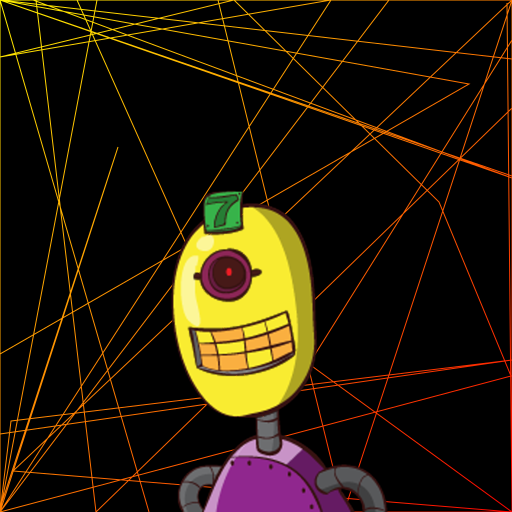

In [213]:
krfr = karafuru(n_colors=2, gradient_type="linear")
bg_img = canvas2img(krfr)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [214]:
eprint(krfr)

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg">
  <defs>
    <linearGradient id="linearGradient" x1="0%" y1="0%" x2="100%" y2="100%" spreadMethod="reflect">
      <stop offset="0%" stop-color="#fff200" stop-opacity="1.0"/>
      <stop offset="100%" stop-color="#ff0300" stop-opacity="1.0"/>
    </linearGradient>
  </defs>
  <polygon points="0,512 0,434 512,360 11,421 0,512 0,354 469,84 0,0 0,331 0,512 118,147 0,508 0,143 0,512 97,0 0,0 512,0 512,59 0,0 512,176 512,178 512,40 309,364 512,512 512,198 512,108 96,512 36,0 512,0 344,512 218,0 77,0 306,512 512,512 507,3 512,512 13,471 512,0 33,0 512,178 0,0 149,512 0,0 389,0 0,512 331,0 0,57 234,0 439,202 511,376" style="stroke: url(#linearGradient); stroke-opacity: 1; stroke-width: 1;"/>
</svg>



In [215]:
from random import choice, randint


def randspace(start, stop, n_samples):
    return sorted(set(randint(start, stop) for _ in range(n_samples)))


def teikoku(
    size: Optional[Size] = None,
    x_density: int = 7,
    y_density: int = 50,
    n_colors: int = 4,
    color_style: str = "pastel",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)
    colors = tuple(RGBColor.randcolor(color_style) for _ in range(n_colors))

    for yi in linspace(0, size.height, y_density):

        n_lines = randint(1, x_density)
        chunks = randspace(0, size.width, n_lines * 2)

        for i in range(0, len(chunks), 2):
            try:
                startx, endx = chunks[i], chunks[i + 1]
            except IndexError:
                continue
            else:
                line = create_line(
                    start=Point(startx, yi),
                    stop=Point(endx, yi),
                    color=choice(colors),
                    width=5,
                    linecap="round",
                )
                canvas.append(line())
    return canvas

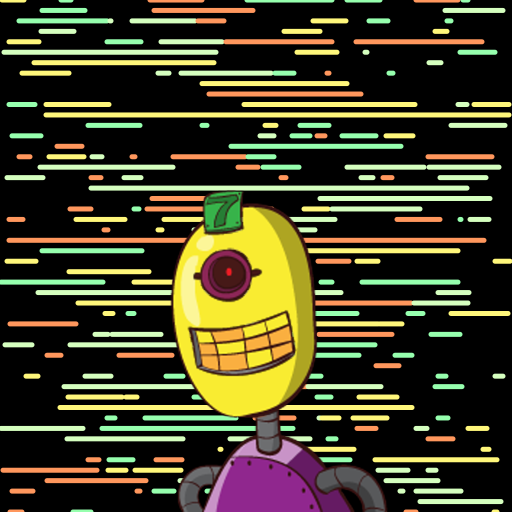

In [216]:
tkk = teikoku(color_style="pastel")
bg_img = canvas2img(tkk)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [217]:
from random import choice

# https://github.com/hogesonline/svg_play/blob/master/maze_for_web.py
def meiro(
    size: Optional[Size] = None,
    color: Optional[str] = None,
    num: int = 30,
    color_style: str = "pastel",
    randwidth: bool = False,
):
    if color is None:
        color = RGBColor.randcolor(color_style)
    else:
        color = RGBColor.from_fex(color)

    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)
    step = size.height // num

    for x in range(0, size.width, step):
        for y in range(0, size.height, step):
            width = randint(1, 3) if randwidth else 2
            if choice([True, False]):
                start, stop = Point(x, y), Point(x + step, y + step)
            else:
                start, stop = Point(x + step, y), Point(x, y + step)
            line = create_line(start, stop, color, width)
            canvas.append(line())
    return canvas

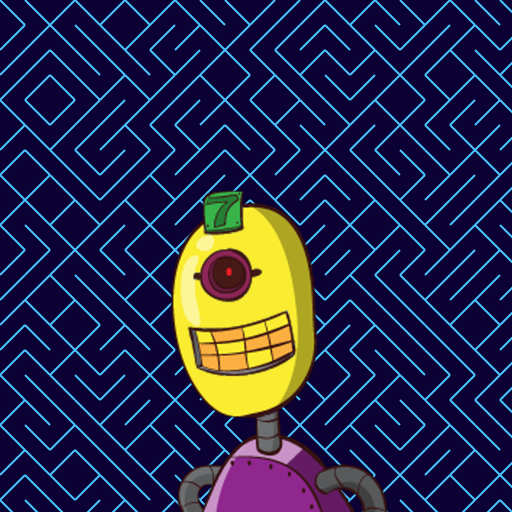

In [218]:
mr = meiro(num=20)
# eprint(mz)
bg_img = canvas2img(mr, background_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [219]:
@define
class Rectangle(ExtendedElement):
    location: Point
    size: Size
    corner_radius: tuple[int, int] = (0, 0)

    def __attrs_post_init__(self) -> None:
        tags = ("x", "y", "width", "height", "rx", "ry")
        vals = (
            str(v)
            for v in chain(self.location, self.size, self.corner_radius)
        )
        self._element = Element("rect", attrib=dict(zip(tags, vals)))

    @classmethod
    def make_rectangle(
        cls, x: float, y: float, width: float, height: float
    ) -> "Rectangle":
        return cls(Point(x, y), Size(width, height))


In [220]:
rect = Rectangle.make_rectangle(0, 0, 50, 50)
rect.set_style(Stroke(color="red", width=1))
eprint(rect())

<rect x="0" y="0" width="50" height="50" rx="0" ry="0" style="stroke: red; stroke-opacity: 1; stroke-width: 1;"/>



In [221]:
from itertools import compress

# https://www.geeksforgeeks.org/sieve-of-eratosthenes/
def sieve_of_eratosthenes(n):
    is_prime = [True for _ in range(n + 1)]
    p = 2

    while p * p <= n:
        if is_prime[p]:
            for i in range(p * p, n, p):
                is_prime[i] = False
        p += 1
    return is_prime


def primes_upto(n: int):
    result = compress(range(n), sieve_of_eratosthenes(n))
    return tuple(result)

In [222]:
def mondrian(
    size: Optional[Size] = None,
    y_density: int = 125,
    n_colors: Optional[int] = None,
    color_style: str = "neon",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    if n_colors is None:
        colors = ("#f7352f", "#017bfc", "#fad000", "black", "white")
    else:
        colors = list(
            RGBColor.randcolor(color_style).to_hex() for _ in range(n_colors)
        )
        colors += ["black", "white"]

    levels = linspace(0, size.height, y_density)

    for y in levels:
        x = 0
        try:
            height = next(levels)
        except StopIteration:
            break
        while x <= size.width:
            rect = Rectangle(
                location=Point(x, y),
                size=((x := x + randint(0, size.width)), height),
            )

            color = choice(colors)
            rect.apply_styles(Fill(color=color), Stroke(color, width=0))
            canvas.append(rect())

    return canvas

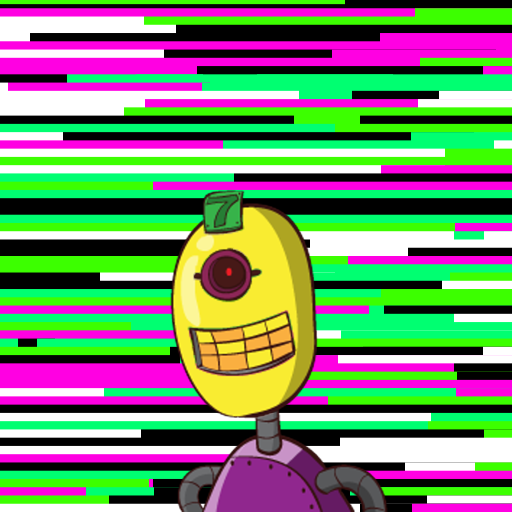

In [223]:
mdr = mondrian(n_colors=3)
bg_img = canvas2img(mdr)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [224]:
def spiral_curve(n, scale=1, step=1):
    for i in range(0, n, step):
        yield (i, scale * radians(i))

In [225]:
list(
    Point.from_polar_radians(r, t)
    for r, t in spiral_curve(360, scale=0.1, step=2)
)

[Point(x=0.0, y=0.0),
 Point(x=1.9999878153155808, y=0.006981302830447464),
 Point(x=3.999902522821579, y=0.02792504119184621),
 Point(x=5.999671016193073, y=0.06283070469747476),
 Point(x=7.999220192074434, y=0.11169744271316218),
 Point(x=9.998476951563912, y=0.17452406437283513),
 Point(x=11.997368201698146, y=0.25130903860028353),
 Point(x=13.995820856936565, y=0.34205049413714417),
 Point(x=15.99376184064567, y=0.4467462195771021),
 Point(x=17.991118086583167, y=0.5653936634063093),
 Point(x=19.987816540381914, y=0.6979899340500194),
 Point(x=21.983784161033665, y=0.8445317999254386),
 Point(x=23.9789479223726, y=1.0050156895007911),
 Point(x=25.973234814558584, y=1.1794376913605984),
 Point(x=27.966571845560154, y=1.3677935542771713),
 Point(x=29.958886042637214, y=1.5700786872883148),
 Point(x=31.950104453823393, y=1.7862881597812417),
 Point(x=33.94015414940802, y=2.0164167015826955),
 Point(x=35.92896222341778, y=2.2604587030552814),
 Point(x=37.916455795097896, y=2.5184082152

## SVG Path

In [227]:
@decorator
def _make_relative(func: Callable[..., str], *args, **kwds):
    result = func(*args, **kwds)
    prev_ops, _, latest_op = result._element.get("d").rpartition(" ")
    result.set("d", prev_ops + _ + latest_op.lower())
    return result



@define
class Path(ExtendedElement):
    def __attrs_post_init__(self) -> None:
        self._element = Element("path", d="")  # type: ignore

    def _update(self, value: str) -> None:
        ops = self._element.get("d")
        self._element.set("d", ops + value)

    @chainable
    def M(self, x: float, y: float) -> str:
        return f" M{x},{y}"

    m = _make_relative(M)

    @chainable
    def L(self, x: float, y: float) -> str:
        return f" L{x},{y}"

    l = _make_relative(L)  # noqa

    @chainable
    def Q(self, x1: float, y1: float, x: float, y: float) -> str:
        return f" Q{x1},{y1} {x},{y}"

    q = _make_relative(Q)

    @chainable
    def C(
        self, x1: float, y1: float, x2: float, y2: float, x: float, y: float
    ) -> str:
        return f" C{x1},{y1} {x2},{y2} {x},{y}"

    c = _make_relative(C)

    @chainable
    def A(
        self,
        rx: float,
        ry: float,
        x_rotation: float,
        large_arc_flag: bool,
        sweep_flag: bool,
        x: float,
        y: float,
    ) -> str:
        return (
            f" A{rx},{ry} {x_rotation} {large_arc_flag},{sweep_flag} {x},{y}"
        )

    a = _make_relative(A)

    @chainable
    def Z(self) -> str:
        return " Z"

    z = _make_relative(Z)

In [228]:
path = Path()
stroke = Stroke()
fill = Fill()
path.set_style(stroke)
str(path.M(150, 150).Q(150, 50, 30, 30).m(30, 30).l(50, 150).L(30, 30).Z())

'<path d=" M150,150 Q150,50 30,30 m30,30 l50,150 L30,30 Z" style="stroke: black; stroke-opacity: 1; stroke-width: 1;"/>\n'

In [229]:
@define
class Circle(ExtendedElement):
    radius: float
    center: Point = Point(0, 0)

    def __attrs_post_init__(self) -> None:
        tags = ("cx", "cy", "r")
        vals = (str(v) for v in chain(self.center, (self.radius,)))
        self._element = Element("circle", attrib=dict(zip(tags, vals)))

    @classmethod
    def make_circle(cls, radius: float, cx: float, cy: float) -> "Circle":
        return cls(radius, Point(cx, cy))

cir = Circle.make_circle(5, 100, 100)
str(cir)

'<circle cx="100" cy="100" r="5"/>\n'

In [230]:
from math import sin, cos, tan, radians


def ETriangle(
    location: Point = Point(0, 0), side: float = 120, styless: bool = True
) -> Path:
    """EquilateralTriangle"""
    x, y = location
    half = side // 2
    angle = radians(60)
    path = Path().m(x, y).l(side, 0).l(-half, tan(angle) * half).z()

    if not styless:
        path.apply_styles(Stroke(), Fill(color="none"))
    return path


def XShape(
    location: Point = Point(0, 0), length: float = 120, styless: bool = True
) -> Path:
    x, y = location
    step = length
    path = Path().m(x, y).l(step, step).m(0, -step).l(-step, step)

    if not styless:
        path.apply_styles(Stroke(), Fill(color="none"))

    return path

In [231]:
from attrs import astuple


@define(eq=False, order=False, str=False)
class Use(ExtendedElement):
    href: str
    location: Point = Point(0, 0)
    size: Optional[Size] = None

    def __attrs_post_init__(self) -> None:


        self.href = "#" + self.href

        tags = "href x y".split()
        values = (str(v) for v in (self.href, *self.location))

        if self.size is not None:
            tags += ["width", "height"]
            values = chain(values, (str(i) for i in self.size))

        self._element = Element("use", **dict(zip(tags, values)))

In [232]:
use = Use("something")
str(use)

'<use href="#something" x="0" y="0"/>\n'

In [233]:
from functools import partial

defs = partial(wraps, "defs")
group = partial(wraps, "g")
symbol = partial(wraps, "symbol")

In [234]:
from math import atan
from itertools import chain


def _rotate(theta: float) -> tuple[float, ...]:
    theta = radians(theta)
    return (cos(theta), sin(theta), -sin(theta), cos(theta))


def _relocate(
    start_x: float, start_y: float, theta: float
) -> tuple[float, ...]:
    x, y = start_x, -start_y
    r = hypot(x, y)

    theta = radians(-theta)
    beta = atan(y / x)
    alpha = theta + beta

    l, k = cos(alpha) * r, sin(alpha) * r
    return x - l, k - y


def _self_rotate(
    start_x: float, start_y: float, theta: float
) -> tuple[float, ...]:
    rotation = _rotate(theta)
    relocation = _relocate(start_x, start_y, theta)
    return tuple(chain(rotation, relocation))

In [235]:
RGBColor(255, 255, 255).to_hex()

'#ffffff'

In [236]:
from math import sin, radians
from functools import partial


def fade(
    element: ExtendedElement,
    location: Point = Point(0, 0),
    color: Optional[str] = None,
    scale: Optional[float] = None,
    rotate: Optional[float] = None,
    spread: tuple[int, int] = (20, 25),
    fading_scale: float = 0.7,
    k: int = 3,
) -> ExtendedElement:

    if color is None:
        color = RGBColor.randcolor("pastel").to_hex()

    if scale is None:
        scale = random.randint(5, 25) / 100

    if rotate is None:
        rotate = random.randint(0, 360)

    eid = str(id(element))
    defs_element = defs(group(element, id=eid))

    uses = []
    origin = (0, 0)
    direction = random.choices([-1, 1], k=2)
    width, opacity = 25, 1

    for i in range(k):
        distance = random.choices(range(*spread), k=2)
        new_location = (
            (i * dis * drc) + loc
            for dis, drc, loc in zip(distance, direction, origin)
        )

        use = Use(href=eid, location=new_location)
        use.apply_styles(Stroke(color, opacity, width), Fill(color="none"))

        width *= fading_scale
        opacity *= fading_scale

        uses.append(use)

    _fade = group(defs_element, *uses)
    transform = Transform().translate(*location).scale(scale).rotate(rotate)
    _fade.add_transform(transform)

    return _fade

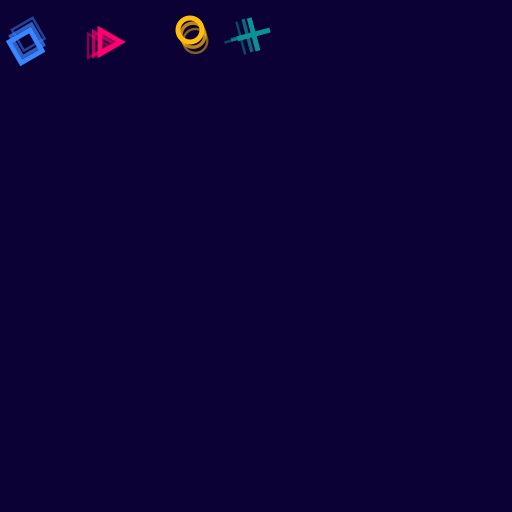

In [237]:
canvas = get_canvas(512, 512)

side = 120

colors = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]

rec = Rectangle(Point(0, 0), Size(side, side))
frec = fade(
    rec, location=Point(30, 30), color="#3a86ff", scale=0.2, rotate=60
)
canvas.append(frec())


tri = ETriangle(side=side)
ftri = fade(
    tri, location=Point(100, 30), color="#ff006e", scale=0.2, rotate=30
)
canvas.append(ftri())


cir = Circle(side // 2)
fcir = fade(cir, location=Point(190, 30), color="#ffbe0b", scale=0.2)
canvas.append(fcir())


x = XShape(length=side)
fx = fade(x, location=Point(270, 30), color="#0a9396", scale=0.2, rotate=120)
canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, background_color="#0c0135")
bg_img

In [238]:
random.choices(range(50, 460), k=2)

[446, 256]

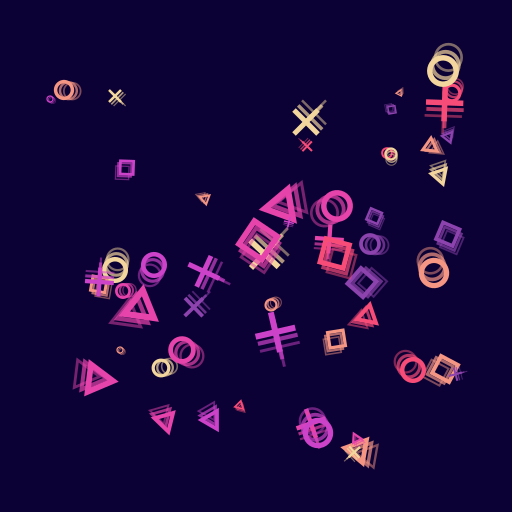

In [239]:
canvas = get_canvas(512, 512)

side = 120
y_axis = 30

colors1 = [RGBColor.randcolor("pastel").to_hex() for _ in range(7)]
colors2 = ["#8d43ad", "#cc43c9", "#e644aa", "#f74c78", "#f49683", "#f2d69d"]
colors3 = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]
colors4 = ["#6e2f74", "#872b73", "#a0256f", "#b62066", "#c9205b", "#d8284c"]

colors = random.choice([colors1, colors2, colors3, colors4])

for y_axis in range(50, 512, 35):
    #     x_axis = range(50, 512, 120)

    rec = Rectangle(Point(0, 0), Size(side, side))
    frec = fade(
        rec,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(frec())

    tri = ETriangle(side=side)
    ftri = fade(
        tri,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(ftri())

    cir = Circle(side // 2)
    fcir = fade(
        cir,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fcir())

    x = XShape(length=side)
    fx = fade(
        x,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, background_color="#0c0135")
bg_img

In [240]:
"""#6e2f74
#872b73
#a0256f
#b62066
#c9205b
#d8284c""".split(
    "\n"
)

['#6e2f74', '#872b73', '#a0256f', '#b62066', '#c9205b', '#d8284c']